### Project #3: Sentiment Analysis of Reviews
Temurjon Ismailov
11/27/24

I want to explore indian restaurants in NJ.  
What are the common themes negative reviews? What are the common themes in positive reviews?
Can we gain insights on common strengths and weaknesses of indian restaurants through this analysis?  
By analyzing customer feedback, we can identify most common review sentiments in Indian restaurants.   

In [50]:
import requests
import time
import pandas as pd
from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer
import matplotlib.pyplot as plt
import ast
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from operator import itemgetter
API_KEY = "9F_s1ES7zWFSsWT8SlhxAhOVK-Tk_5jGtGgyiJhnct4cDXrGdjAMkMdmmeYTqRdVTEJXbWTPCdAh1fas6JAkQrYLhZ9rWbsVXlhIePicia5XV1UOcb3BryAjn986ZHYx"
HEADERS = {"Authorization": f"Bearer {API_KEY}"}



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sbani\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### search_businesses Function
Searches Yelp API for businesses based on location and category. Returns a list of businesses.

In [ ]:
def search_businesses(location, category, term="restaurants", limit=50, max_results=100):
    url = "https://api.yelp.com/v3/businesses/search" 
    businesses = []  # List to store results
    
    params1 = {"location": location, "term": term, "categories": category, "limit": limit, "offset": 0}
    response = requests.get(url, headers=HEADERS, params=params1)  # Send request
    data1 = response.json()  # Parse JSON response
    
    businesses.extend(data1['businesses'])  # Add results to list
    return businesses

### get_reviews Function
Fetches reviews for a specific business using its business_id. Returns a list of reviews.

In [ ]:
def get_reviews(business_id):
    url = f"https://api.yelp.com/v3/businesses/{business_id}/reviews"

    response = requests.get(url, headers=HEADERS)

    # Raise an error if the request fails
    response.raise_for_status()

    # Parse the JSON response to extract reviews
    data = response.json()
    review = data["reviews"]
    
    return review

### extract_text Function
Parses a DataFrame of reviews, extracting the text from cells containing review data. Returns a list of review texts.

In [ ]:
def extract_text(reviews):
    extracted_reviews = []
    
    for _, row in reviews.iterrows():
        for cell in row: 
            # Try block that prevents erroring out
            try:
                review_data = ast.literal_eval(cell)
                if 'text' in review_data:
                    extracted_reviews.append(review_data['text'])
            except Exception as e:
                continue 
    
    return extracted_reviews

### text_cleaner Function
Cleans a list of reviews by removing newline characters and unnecessary spaces. Returns a list of cleaned reviews.

In [27]:
def text_cleaner(reviews):
    cleaned_reviews = []
    for review in reviews:
        clean_words = ""
        words = review.split()
        for word in words:
            clean_words += word + ' '
        clean_words = clean_words.strip().replace("\n", " ")
        cleaned_reviews.append(clean_words)
    return cleaned_reviews

Fetch and Save Indian Restaurants Data

Searches for Indian restaurants in four specified New Jersey counties.

Filters out restaurants with at least 3 reviews.

Saves the results to a CSV file named indian_restaurants.csv to prevent excessive api calls. 

In [ ]:
# Define locations to search for Indian restaurants
location1 = "Morris County, NJ"
location2 = "Bergen County, NJ"
location3 = "Passaic County, NJ"
location4 = "Union County, NJ"

# Initialize an empty list to store restaurant data
indian_restaurants = []

# Search for Indian restaurants ('indpak' category) in each location and extend the list
indian_restaurants.extend(search_businesses(location1, 'indpak'))
indian_restaurants.extend(search_businesses(location2, 'indpak'))
indian_restaurants.extend(search_businesses(location3, 'indpak'))
indian_restaurants.extend(search_businesses(location4, 'indpak'))

# Convert the list of restaurants into a DataFrame
df = pd.DataFrame(indian_restaurants)

df = df[df.review_count >= 3]

df.to_csv('indian_restaurants.csv', index=False)


Fetch and Save Reviews for Restaurants

Reads Indian restaurant data from indian_restaurants.csv.

For each restaurant, fetches reviews using its unique ID.

Saves the collected reviews into a CSV file named reviews.csv.

In [ ]:
# Load the dataset of Indian restaurants from a CSV file
file_path = r"C:\Users\sbani\Desktop\Coding stuff\Data science\Notebooks\indian_restaurants.csv"
restaurants = pd.read_csv(file_path)

reviews = []

# Iterate through the restaurants to fetch their reviews
for restaurant in restaurants.index:
    restaurant_id = restaurants.loc[restaurant, 'id']  # Get the restaurant ID
    try:
        reviews.append(get_reviews(restaurant_id))  # Fetch reviews and append to the list
    except Exception as e:
        print(f"An error occurred for restaurant ID {restaurant_id}: {e}")  
    time.sleep(1)  

# Convert the reviews list to a DataFrame
df = pd.DataFrame(reviews)

# Save the reviews to a CSV file
df.to_csv("reviews.csv")
    

Perform Sentiment Analysis on Restaurant Reviews

Reads review data from reviews.csv.

Extracts and cleans the review text.

Combines the cleaned reviews into a single text string.

Analyzes the sentiment using both TextBlob's default analyzer and NaiveBayesAnalyzer.

Prints sentiment results for both analyzers.

In [ ]:
file_path = r"C:\Users\sbani\Desktop\Coding stuff\Data science\Notebooks\reviews.csv"
reviews = pd.read_csv(file_path)

# Extract the review text from the dataset
reviews_text = extract_text(reviews)

# Clean the extracted review text
cleaned_reviews_text = text_cleaner(reviews_text)

# Combine the cleaned reviews into a single string for late use
review_string_text = "".join(cleaned_reviews_text)

# Perform sentiment analysis using TextBlob
sentiment = TextBlob(review_string_text).sentiment

# Perform sentiment analysis using NaiveBayesAnalyzer
blob = TextBlob(review_string_text, analyzer=NaiveBayesAnalyzer())

# Print the sentiment results
print(sentiment)  
print(blob.sentiment)  

Sentiment(polarity=0.2466347642632054, subjectivity=0.6055330703161628)
Sentiment(classification='pos', p_pos=1.0, p_neg=3.785108856121638e-62)


Generate Sentiment Analysis Distribution as a Donut Chart
Cleaned review text.

Analyzes polarity for each review and classifies it as positive, negative, or neutral.

Computes the percentage distribution of sentiments.

Visualizes the sentiment distribution using a donut chart.


288


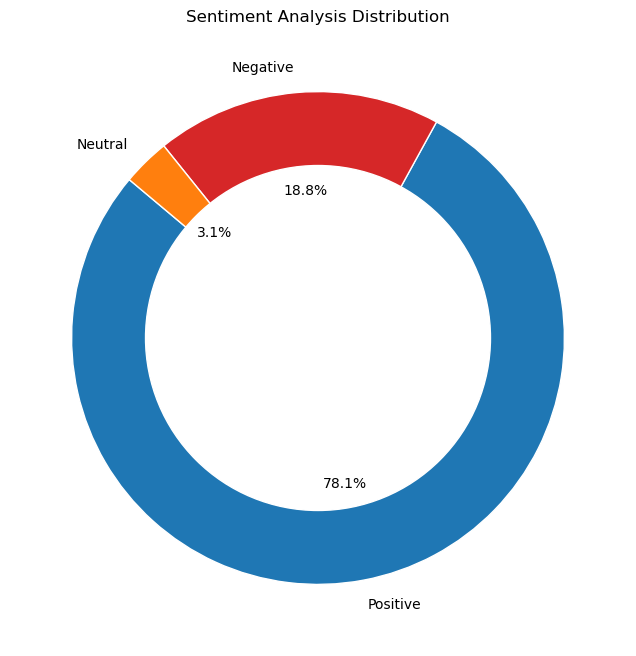

In [ ]:
positive_count = 0
negative_count = 0 
neutral_count = 0

total_reviews = len(cleaned_reviews_text)

# Analyze each review's sentiment
for review in cleaned_reviews_text:
    analysis = TextBlob(review)
    if analysis.sentiment.polarity > 0:  
        positive_count += 1  
    elif analysis.sentiment.polarity < 0:  
        negative_count += 1  
    else: 
        neutral_count += 1  

# Calculate sentiment percentages
positive_percentage = (positive_count / total_reviews) * 100
negative_percentage = (negative_count / total_reviews) * 100
neutral_percentage = (neutral_count / total_reviews) * 100

labels = ['Positive', 'Negative', 'Neutral']
sizes = [positive_percentage, negative_percentage, neutral_percentage]
colors = ['#1f77b4', '#d62728', '#ff7f0e']

# Plot the donut chart
plt.figure(figsize=(8, 8))
plt.pie(
    sizes,
    labels=labels,
    colors=colors,
    autopct='%1.1f%%',
    startangle=140,
    wedgeprops={'linewidth': 1, 'edgecolor': 'white'}
)
plt.gca().add_artist(plt.Circle((0, 0), 0.7, color='white'))  # Add white circle for the donut hole
plt.title('Sentiment Analysis Distribution')
plt.show()

Classifies each review as positive or negative using NaiveBayesAnalyzer.

Counts occurrences for each sentiment category.

Calculates sentiment percentages for visualization.

A donut chart visualizing the sentiment distribution as determined by the NaiveBayesAnalyzer.

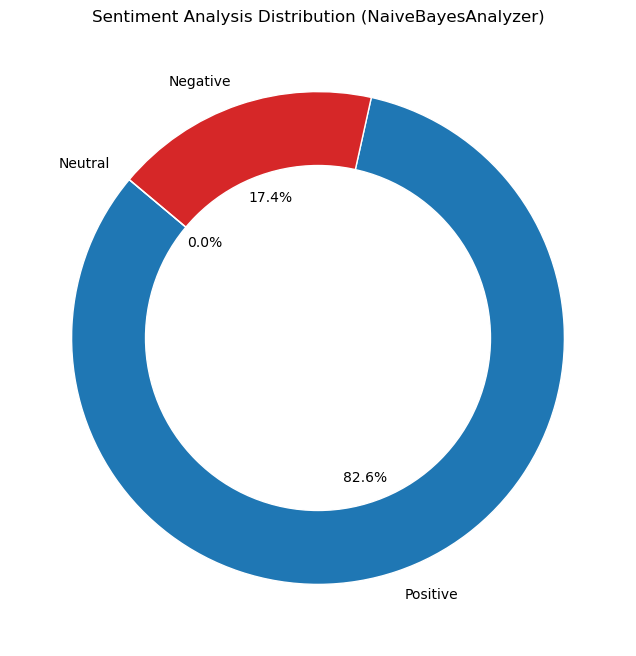

In [ ]:
positive_count = 0
negative_count = 0
neutral_count = 0

total_reviews = len(cleaned_reviews_text)

# Loop through reviews and analyze sentiments using NaiveBayesAnalyzer
for review in cleaned_reviews_text:
    analysis = TextBlob(review, analyzer=NaiveBayesAnalyzer())
    if analysis.sentiment.classification == 'pos':  
        positive_count += 1
    elif analysis.sentiment.classification == 'neg':  
        negative_count += 1
    else: 
        neutral_count += 1

# Calculate percentages
positive_percentage = (positive_count / total_reviews) * 100
negative_percentage = (negative_count / total_reviews) * 100
neutral_percentage = (neutral_count / total_reviews) * 100

labels = ['Positive', 'Negative', 'Neutral']
sizes = [positive_percentage, negative_percentage, neutral_percentage]
colors = ['#1f77b4', '#d62728', '#ff7f0e']

# Plot the donut chart
plt.figure(figsize=(8, 8))
plt.pie(
    sizes,
    labels=labels,
    colors=colors,
    autopct='%1.1f%%',
    startangle=140,
    wedgeprops={'linewidth': 1, 'edgecolor': 'white'}
)
plt.gca().add_artist(plt.Circle((0, 0), 0.7, color='white'))  # Add white circle for the donut hole
plt.title('Sentiment Analysis Distribution (NaiveBayesAnalyzer)')
plt.show()

The code processes a collection of reviews to identify the top 20 most frequent words after filtering out stop words

In [ ]:

# Define a set of stop words and add custom ones
stop_words = set(stopwords.words('english'))
stop_words.update(["came", "got", "like", "went", "always", "realy", "really", "n't", "ordered"])

# Create a TextBlob object from the review text to process word frequencies
blob = TextBlob(review_string_text)

# Get word counts as a list of tuples (word, frequency)
items = blob.word_counts.items()

# Remove words that match the stop words list
items = [item for item in items if item[0] not in stop_words]

# Sort the remaining words by their frequencies in descending order
sorted_items = sorted(items, key=itemgetter(1), reverse=True)

# Select the top 20 words and their counts
top_20 = sorted_items[0:21]

# Create a DataFrame to organize the results
df = pd.DataFrame(top_20, columns=['word', 'count'])

df


,word,count
0,food,152
1,indian,86
2,good,72
3,chicken,65
4,place,64
5,great,59
6,restaurant,51
7,service,40
8,time,30
9,amazing,24


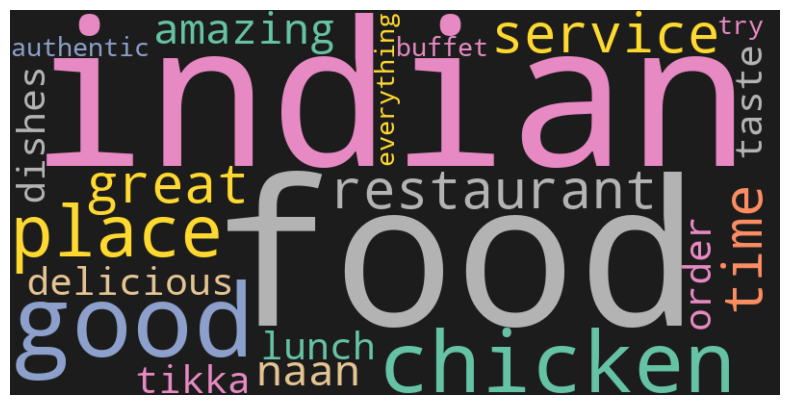

In [ ]:
from wordcloud import WordCloud

# Combine the top 20 words into a single string
top_20_string = " ".join(df["word"])

# Generate a word cloud
wordcloud = WordCloud(width=800, height=400, colormap='Set2', background_color="#1C1C1C").generate(top_20_string)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()
